### Tight-Binding model

In [1]:
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
#from bokeh.io import output_file

from bokeh.io import output_notebook, show
from bokeh.layouts import column, row
from bokeh.plotting import figure, gridplot
from IPython.display import display 
%matplotlib inline

sns.set(style='white')
output_notebook()

Loading BokehJS ...

In [2]:
#---> settings
a = 1.0
c  = 4.0
ncells = 24
rmax =4.0
m = -0.5
t2 = 0.25
lmda = 0.5
C = np.exp(1.0)
density= 1.0
nstates = 2


(24, 4) RangeIndex(start=0, stop=24, step=1) Index(['x', 'y', 'r', 'c'], dtype='object')
          x         y         r   c
0  0.219996 -0.673260  0.972943  a1
1 -0.306571 -0.846955  0.863440  a2
2 -0.498640  0.182598 -1.381966  a3


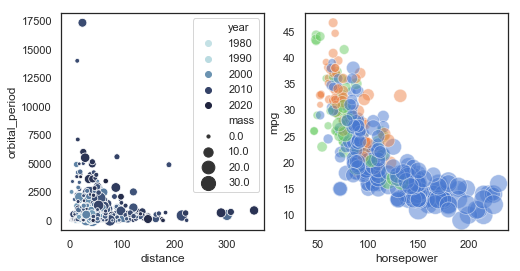

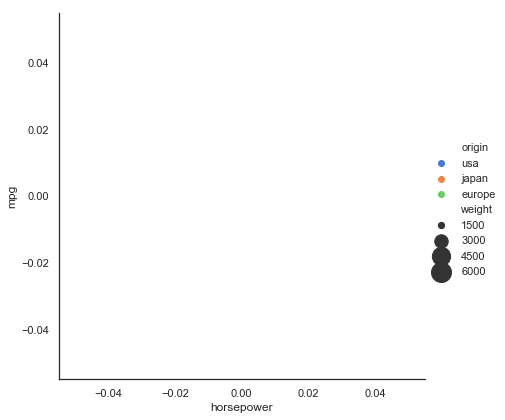

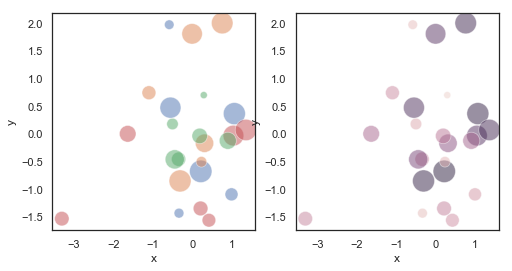

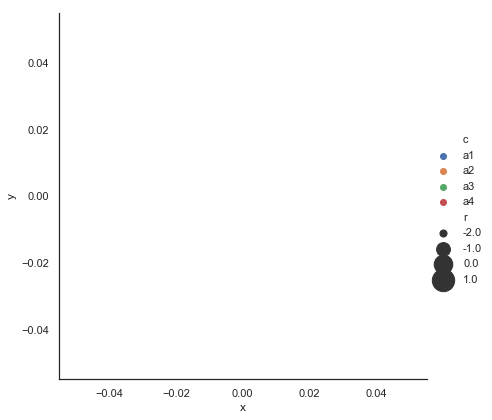

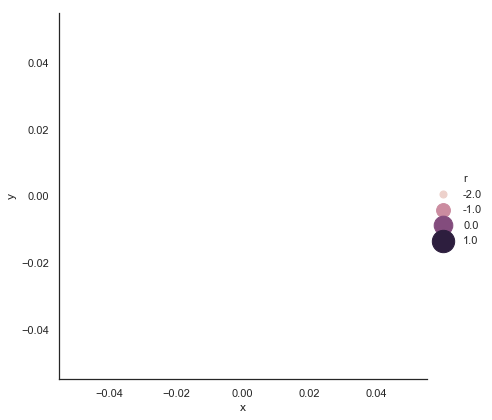

In [3]:
# Test the scatter plot 
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

planets = sns.load_dataset("planets")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.scatterplot(x="distance", y="orbital_period",
                     hue="year", size="mass",
                     palette=cmap, sizes=(10, 200),
                     data=planets, ax=axes[0])

mpg = sns.load_dataset("mpg")
sns.relplot(x="horsepower", y="mpg", hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=mpg, ax=axes[1])

data=np.random.randn(24,3)
labels = ['a1', 'a2', 'a3', 'a4']*6

df=DataFrame(data, columns=['x', 'y', 'r'])
df['c'] = labels
print(df.shape, df.index, df.columns)
print(df[:3])
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
sns.relplot(x='x', y='y', hue='c', size='r', alpha=0.5, height=6, sizes=(50,500), data=df, ax=axes[0])
sns.relplot(x='x', y='y', hue='r', size='r', alpha=0.5, height=6, sizes=(50,500), data=df, ax=axes[1])

In [96]:
#--> functions for get lattices, hamiltonian and eigs.
def get_honycomb_lattice(a=1.0, c=4.0, ncells=4, ax=None):
    test = True
    cell = np.array([[0.5*a, 0.5*a*np.sqrt(3), 0.0], [0.5*a, -0.5*a*np.sqrt(3), 0.0], [0.0, 0.0, c/2]])
    spos = np.array([[1/3, 2/3, 0], [2/3, 1/3, 0]])
    pos = spos @ cell
    
    
    pos = np.array([pos + [i,j,k] @ cell for i in range(ncells) for j in range(ncells) for k in [1]])
    pos = np.concatenate(pos)

    pos_1 = pos @ rotate_z(2 * np.pi / 3.0)
    pos_2 = pos @ rotate_z(4*np.pi / 3.0)

    if ax:
        show_unitcell(cell, ax=ax)
        colors = 'rgb'
        for _c, _pos in zip(colors, (pos, pos_1, pos_2)):
            ax.scatter(*_pos[:, :2].T)
            
    pos = np.concatenate([pos, pos_1, pos_2])
        
    return cell, pos

def get_random_lattice(a=1.0, ncells=4, density=1.0, ax=None):
        cell = a * ncells * np.eye(3)
        pos = a*ncells * np.random.rand(int(np.ceil(ncells * ncells * density)), 3)
        if ax:
            show_unitcell(cells, ax)
        return cell, pos

def rotate_z(theta):
        return np.array([[np.cos(theta), np.sin(theta), 0.0],[-np.sin(theta), np.cos(theta), 0.0], [0, 0, 1.0]])

def show_unitcell(cell, ax=None, dim=2):
    if dim==2:
        _cell = cell[0:2, 0:2]
        unitcell = np.array([[0.0, 0.0],_cell[0], _cell[0]+_cell[1], _cell[1], [0.0, 0.0]])
        ax.plot(*unitcell.T, c='k')
    elif dim==3:
        print('not implemented.')
        pass
    
def get_hamiltonian(cell, pos, ncells=4, nstates=2, a=1.0, C=np.exp(1), t2=0.25, lmda=0.5, m=0.5, rmax=4.0, fac_theta=-1):
    nsites = len(pos)
    hsize = nstates*nsites
    h = np.zeros((hsize, hsize), dtype=complex)
    for i in range(nsites):
        for j in range(nsites):
            if i==j:
                _i = i * nstates
                h[_i, _i] += 2 + m
                h[_i+1, _i+1] += - (2+m)
                h[_i, _i+1] += (1-1j) * lmda
                h[_i+1, _i] += (1+1j) * lmda
            else:
                _pos = pos[j] - pos[i]
                rij = np.linalg.norm(_pos)
                theta = np.angle(_pos[0]+_pos[1]*1j)
                if rij < rmax:
                    _i = i * nstates
                    _j = j * nstates
                    t = C * np.exp(-rij/a)

                    h[_i, _j] += t*0.5*(-1+t2)
                    h[_i+1, _j+1]  += t*0.5*(1+t2)
                    h[_i, _j+1] += t*0.5*(-1j*np.exp(-1j*theta) + lmda*((1+1j)*np.sin(theta)**2 - 1.0))
                    h[_i+1, _j] += t*0.5*(-1j*np.exp(1j*theta) + lmda*((1-1j)*np.sin(theta)**2 - 1.0))

    return h
                    
def get_eigs(h, sort=True):
    val, vec = np.linalg.eig(h)
#    print(val.shape, vec.shape)
    if sort:
        val_vec = sorted([_ for _ in zip(val, vec)], key=lambda x:x[0])
        val = np.array([_[0] for _ in val_vec])
        vec = np.array([_[1] for _ in val_vec])
    return val, vec

def test_cell(a, c, ncells):
    fig, axes = plt.subplots(ncols=2, figsize=(12,6))
    ax = axes[0]
    cell, pos = get_random_lattice(a, ncells, ax=ax)
    ax.axis('equal')
    ax.grid()
    ax.scatter(*pos[:, :2].T)    

    ax = axes[1]
    cell, pos = get_honycomb_lattice(a, c, ncells, ax=ax)
    ax.axis('equal')
    ax.grid()
#    ax.scatter(*pos[:, :2].T)
    
def gauss(x, mu, sigma=0.5):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mu)**2/2/sigma**2)

def get_dos(x, val, sigma=0.5):
    y = np.zeros_like(x)
    for i, _x in enumerate(x):
        for _y in val:
            y[i] += gauss(_x, _y, sigma)
    return y

In [97]:
_theta = np.pi/3
hij = 1j*np.exp(-1j*_theta) , lmda*((1+1j)*np.sin(_theta)**2 - 1.0)
_theta *= -1
hji = 1j*np.exp(1j*_theta),  lmda*((1+1j)*np.sin(_theta)**2 - 1.0)
print(hij)
print(hji)

((0.8660254037844386+0.5000000000000001j), (-0.12500000000000006+0.37499999999999994j))
((0.8660254037844386+0.5000000000000001j), (-0.12500000000000006+0.37499999999999994j))


[[ 1.5+0.j  0.5+0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
 [ 0.5+0.j -1.5+0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  1.5+0.j ...  0. +0.j  0. +0.j  0. +0.j]
 ...
 [ 0. +0.j  0. +0.j  0. +0.j ... -1.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  1.5+0.j  0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0.5+0.j -1.5+0.j]]


/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/numpy/lib/histograms.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)


(0.2035034601070291-2.5750068254970864e-17j)
(-0.09649653989297088-2.5750068254970864e-17j) (0.5035034601070291-2.5750068254970864e-17j)


/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/matplotlib/transforms.py:2059: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)
/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


14
(14, 196)
4 4


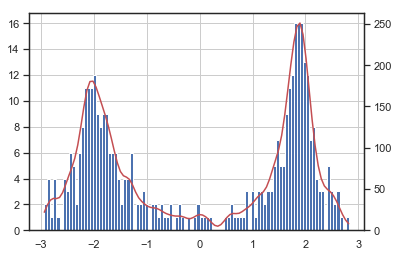

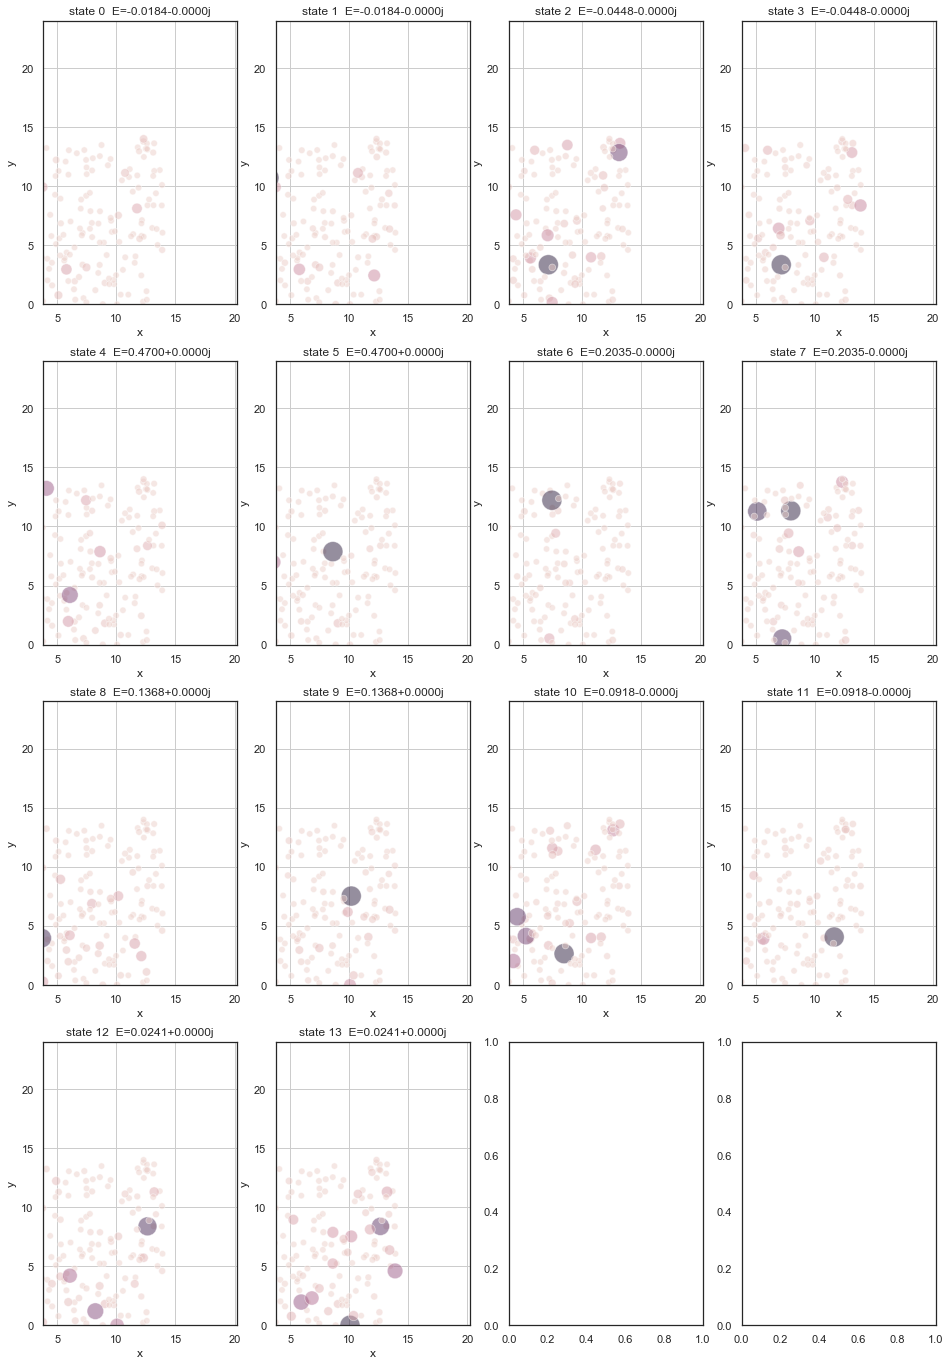

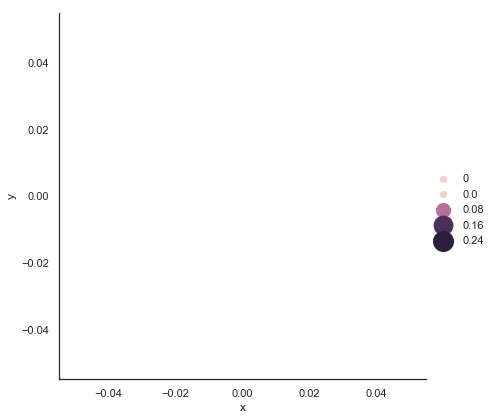

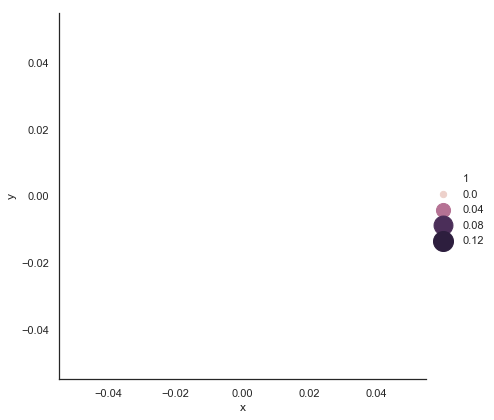

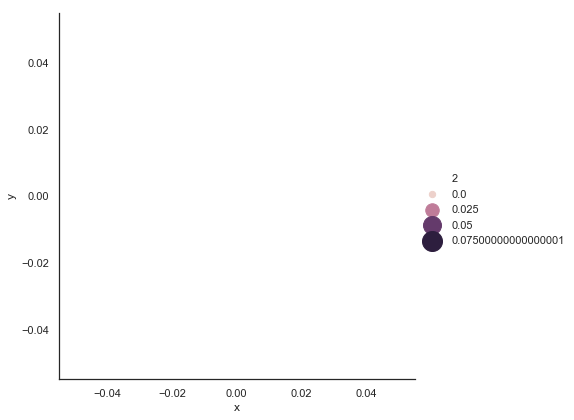

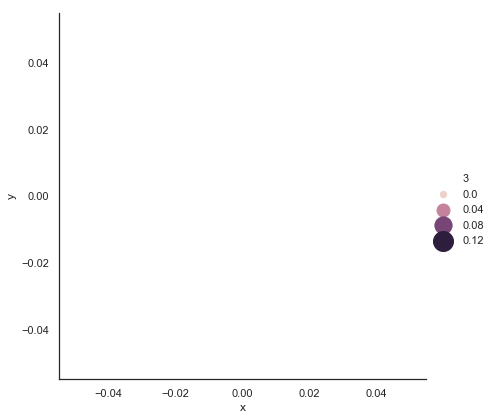

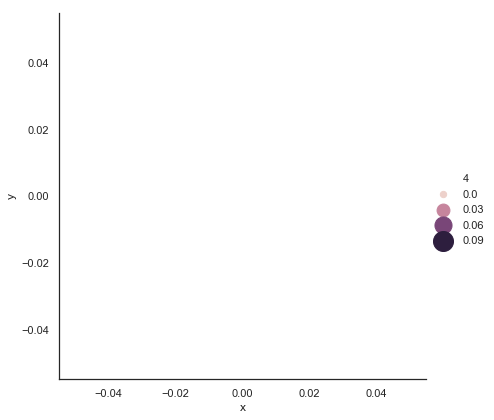

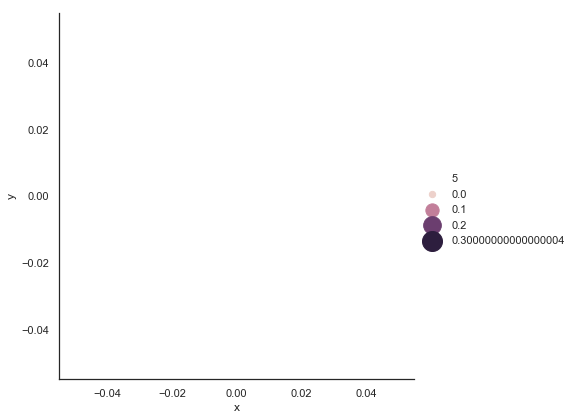

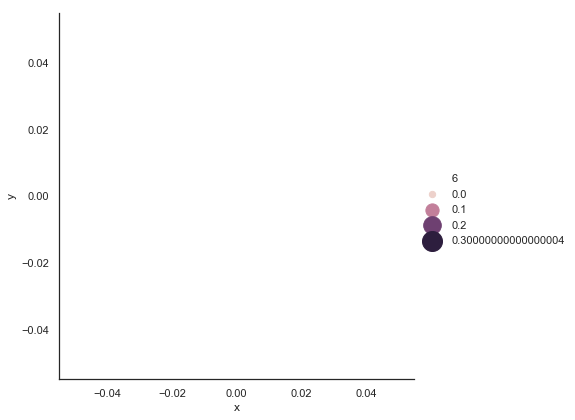

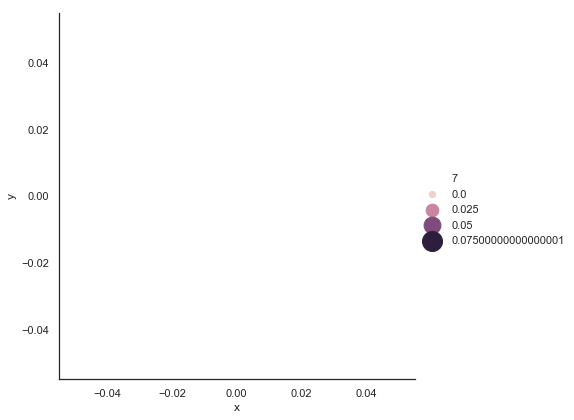

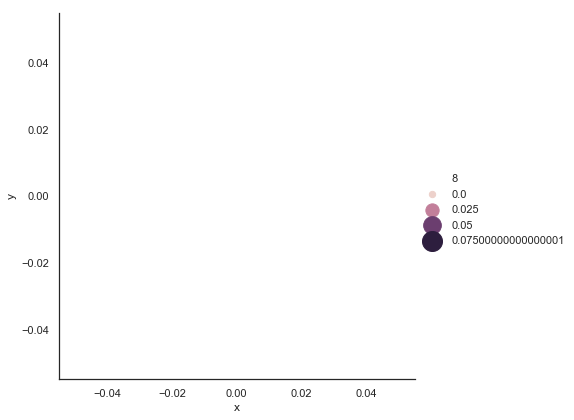

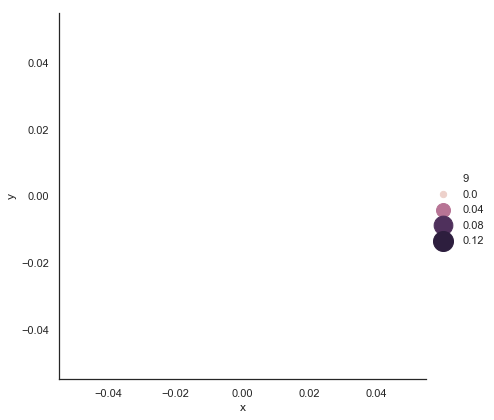

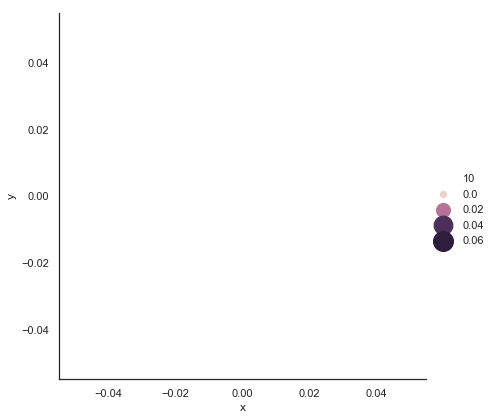

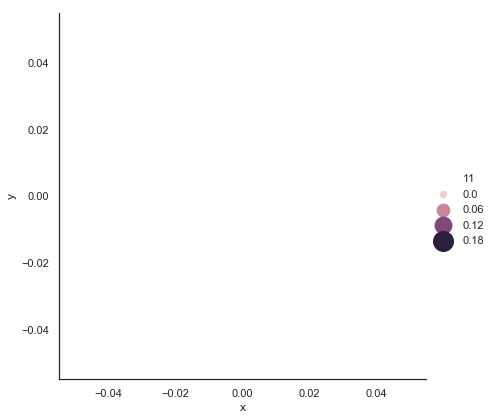

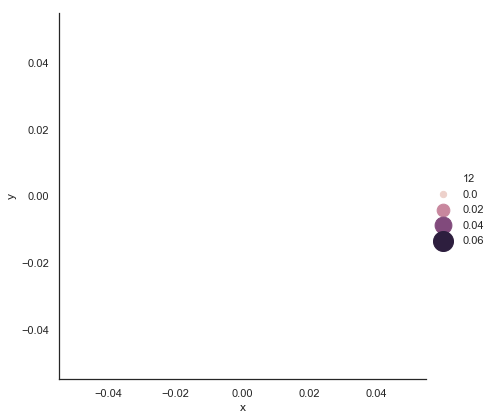

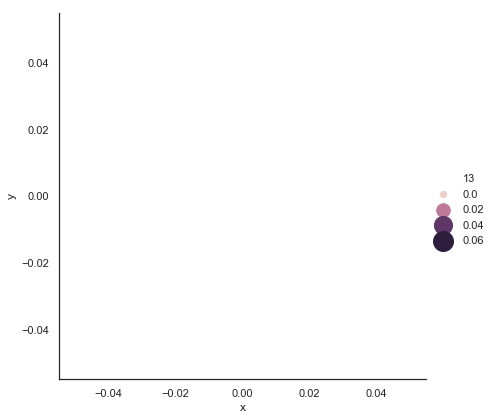

In [98]:
#--> test the eigenvalues and the eigenfunctions.
#--> 
def test_get_random(ncells=4, nstates=2, density=1.0, a=1.0, C=np.exp(1), t2=0.25, lmda=0.5, m=0.5, rmax=4):
    cell, pos = get_random_lattice(a=a, ncells=ncells, density=density)
    h = get_hamiltonian(cell, pos, ncells=ncells, nstates=nstates, 
                                        a=a, C=C, t2=t2, lmda=lmda, m=m, rmax=rmax)
    print(0.5*(h+h.T))
    val, vec = get_eigs(h, sort=False)
    return cell, pos, val, vec

_ncells=14
cell, pos, val, vec = test_get_random(ncells=_ncells, nstates=nstates, 
                                 density=density, a=a, C=C, t2=t2, lmda=lmda, m=m, rmax=rmax)
nbins = 100
hist, bins = np.histogram(val, bins=nbins)

ef = sorted(val)[:len(pos)][-1]
ev, ec = ef-0.3, ef+0.3
print(ef)
print(ev,ec)
mask = (val < ec ) & (val > ev)
nvecs = mask.tolist().count(True)
dos = get_dos(bins, val, sigma=0.1)

fig = plt.figure()
ax = fig.gca()
ax.hist(val, bins=100)
_ax = ax.twinx()
_ax.plot(bins, dos, color='r')
_ax.set_ylim((0.0, None))
ax.grid()

data = []
e = []
if np.any(mask):
    for i, (_vec, _val) in enumerate(zip(vec[mask], val[mask])):
        w = np.real(_vec.conjugate() * _vec)
        w_up, w_dn = w[::2], w[1::2]
        data.append(w_up)
        data.append(w_dn)
        e.extend([_val, _val])

data=np.array(data)
x, y = pos[:, 0], pos[:, 1]
n = len(data)
print(n)
df = DataFrame(data.T)
df['x']  = x
df['y'] = y

ncols=4
nrows = int(np.ceil(n/ncols))
print(data.shape)
print(ncols, nrows)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16,6*nrows))

box  = [a*ncells, a*ncells]
for i in range(len(data)):
    _ix = i % ncols
    _iy = i // ncols
    _ax = axes[_iy, _ix]
    p = sns.relplot(x='x', y='y', hue=i, size=i, 
            sizes=(40, 400), alpha=.5,
            height=6, data=df, ax=_ax)
    _ax.grid()
    _ax.axis('equal')
    _df = df[[i, 'x', 'y']]
    _ax.set_title('state {}  E={:8.4f}'.format(i, e[i]))
    _ax.set_xlim(0, box[0])
    _ax.set_ylim(0, box[1])


### Bott Index

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Projector 

\begin{eqnarray}
P &=& \sum_{j=1}^{N_{occ}}\ket{\psi_j^O}\bra{\psi_j^0} \\
\end{eqnarray}

The positions (x, y) are mapped on torus given by ($\theta$, $\phi$),

where $\theta$ and $\phi$ are scaled positions in [0, $2\pi$)

\begin{eqnarray}
U &=& P \exp(i\Theta)P \\
  &=& \sum_{j,i}^{N_{occ}}  \ket{\psi_j^O}\bra{\psi_j^O} \exp(i\Theta) \ket{\psi_i^O}\bra{\psi_i^O} \\
U^{\dagger} &=& (P \exp(i\Theta)P)^{\dagger} \\
  &=& \sum_{j,i}^{N_{occ}}  \ket{\psi_j^O}\bra{\psi_j^O} \exp(-i\Theta) \ket{\psi_i^O}\bra{\psi_i^O} \\
W &=& P \exp(i \Phi) P \\
  &=& \sum_{l,m}^{N_{occ}}  \ket{\psi_l^O}\bra{\psi_l^O} \exp(i\Phi) \ket{\psi_m^O}\bra{\psi_m^O} \\
W^{\dagger} &=& (P \exp(i \Phi) P)^{\dagger} \\
  &=& \sum_{l,m}^{N_{occ}}  \ket{\psi_l^O}\bra{\psi_l^O} \exp(-i\Phi) \ket{\psi_m^O}\bra{\psi_m^O} \\
\end{eqnarray}


\begin{eqnarray}
WU &=& \sum_{i,j,l,m}^{N_{occ}}  \ket{\psi_j^O}\bra{\psi_j^O} \exp(i\Theta) \ket{\psi_i^O}\braket{\psi_i^O}{\psi_l^O}\bra{\psi_l^O} \exp(i\Phi) \ket{\psi_m^O}\bra{\psi_m^O} \\
    &=&  \sum_{i,j,m}^{N_{occ}}  \ket{\psi_j^O}\bra{\psi_j^O} \exp(i\Theta) \ket{\psi_i^O}\bra{\psi_i^O} \exp(i\Phi) \ket{\psi_m^O}\bra{\psi_m^O} \\
    WUW^{\dagger}U^{\dagger} &=& \sum_{i,j,l}^{N_{occ}}  \ket{\psi_j^O}\bra{\psi_j^O} \exp(i\Theta) \ket{\psi_i^O}\bra{\psi_i^O} \exp(i\Phi) \ket{\psi_l^O}\bra{\psi_l^O}  \sum_{m, n, k}^{N_{occ}}  \ket{\psi_m^O}\bra{\psi_m^O} \exp(-i\Theta) \ket{\psi_n^O}\bra{\psi_n^O} \exp(-i\Phi) \ket{\psi_k^O}\bra{\psi_k^O} \\
    &=& \sum_{i,j,l,m,n}^{N_{occ}}  \ket{\psi_j^O}\bra{\psi_j^O} \exp(i\Theta) \ket{\psi_i^O}\bra{\psi_i^O} \exp(i\Phi) \ket{\psi_l^O} \bra{\psi_l^O} \exp(-i\Theta) \ket{\psi_m^O}\bra{\psi_m^O} \exp(-i\Phi) \ket{\psi_n^O}\bra{\psi_n^O} \\
\end{eqnarray}

\begin{eqnarray}
\mathrm{tr} ( \mathrm{log}(WUW^{\dagger}U^{\dagger})) &=& \mathrm{log} \left[ \sum_{i,j,k,m}^{N_{occ}}  \bra{\psi_i^O} \exp(i\Theta) \ket{\psi_j^O}\bra{\psi_j^O} \exp(i\Phi) \ket{\psi_k^O} \bra{\psi_k^O} \exp(-i\Theta) \ket{\psi_l^O}\bra{\psi_l^O} \exp(-i\Phi) \ket{\psi_i^O} \right] \\
\end{eqnarray}


\begin{eqnarray}
(\mathrm{Bott\,Index}) &=& \frac{1}{2 \pi} \mathrm{Im} (\mathrm{tr}(\mathrm{log}(WUW^{\dagger}U^{\dagger})))
\end{eqnarray}

-0.2652622784280939


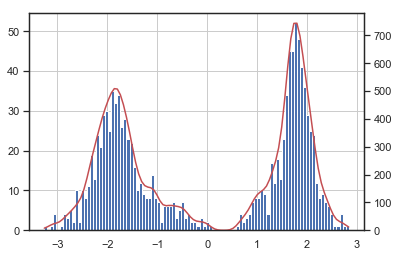

In [69]:
#--> main 

def get_random(ncells=4, nstates=2, density=1.0, a=1.0, C=np.exp(1), t2=0.25, lmda=0.5, m=0.5, rmax=4, fac_theta=-1.0):
    cell, pos = get_random_lattice(a=a, ncells=ncells, density=density)
    h = get_hamiltonian(cell, pos, ncells=ncells, nstates=nstates, 
                                        a=a, C=C, t2=t2, lmda=lmda, m=m, rmax=rmax, fac_theta=fac_theta)
    val, vec = get_eigs(h, sort=False)
    
#    nocc = len(pos)
#    efermi = sorted(val)[:nocc][-1]
#    mask  =val < efermi

    bott_index = get_bott_index(cell, pos, eigenvals=val, eigenvecs=vec)
    
    return cell, pos, val, vec, bott_index

def get_bott_index(cell, pos, eigenvals=None, eigenvecs=None):
    nocc = len(pos)
    efermi = sorted(eigenvals)[:nocc][-1]
    mask  = eigenvals < efermi
        
    if len(mask)==len(pos)*2:
        pos2 = np.concatenate([[_, _] for _ in pos])
    else:
        pos2 = pos
    
    a = np.linalg.norm(cell, axis=1)
    theta = np.diag(2 * np.pi * pos2[:, 0]/a[0])
    phi = np.diag(2* np.pi * pos2[:, 1]/a[1])
    vecs_occ = eigenvecs[mask]
    U = np.matrix(np.exp(theta*1j))
    W = np.matrix(np.exp(phi*1j))
    
    U = vecs_occ @ U @ vecs_occ.T
    W = vecs_occ @ W @ vecs_occ.T

    t = np.matrix(np.log(W @ U @ W.H @ U.H)).trace()[0, 0]
    bott_index = t.imag/(2*np.pi)
    return bott_index
    
cell, pos, val, vec, bott_index = get_random(ncells=ncells, nstates=nstates, density=density, a=a, C=C, t2=t2, lmda=lmda, m=m, rmax=rmax)
nbins = 100
hist, bins = np.histogram(val, bins=nbins)
dos = get_dos(bins, val, sigma=0.1)

print(bott_index)

fig = plt.figure()
ax = fig.gca()
ax.hist(val, bins=100)
_ax = ax.twinx()
_ax.plot(bins, dos, color='r')
_ax.set_ylim((0.0, None))
ax.grid()



In [70]:
_theta=2*np.pi/2
_phi = np.pi/2
tmp = np.array([[1, 0, -1j*np.cos(_theta), -1j*np.exp(-1j*_theta)*np.sin(_theta)], 
           [0, 1, -1j*np.exp(1j*_phi)*np.sin(_theta), 1j*np.cos(_theta)], 
           [-1j*np.cos(_theta), -1j*np.exp(-1j*_phi)*np.sin(_theta), -1, 0],
           [-1j*np.exp(1j*_phi)*np.sin(_theta), 1j*np.cos(_theta), 0, -1]])
tmp = np.matrix(tmp)
np.round(tmp.H - tmp, 4)

matrix([[ 0.-0.j,  0.-0.j,  0.-2.j,  0.-0.j],
        [ 0.-0.j,  0.-0.j, -0.+0.j,  0.+2.j],
        [ 0.-2.j,  0.+0.j,  0.-0.j,  0.-0.j],
        [-0.-0.j,  0.+2.j,  0.-0.j,  0.-0.j]])

In [71]:
print('a={:8.4f}\nC={:8.4f}\nt2={:8.4f}\nlambda={:8.4f}\nM={:8.4f}\nRmax={:8.4f}\ndensity={:8.4f}'.format(a, C, t2, lmda, m, rmax, density))
print('ncells={:8d}\nnstates={:8d}'.format(ncells, nstates))
ntrial = 100
vals, vecs, botts = [], [], []
data = []
nd = 16
nm = 16
for _i, _d in enumerate(np.linspace(0.25, 1, nd)):
    for _j,_m in enumerate(np.linspace(-4, 4, nm)):
        print('{:d} {:d} {:10.4f}{:10.4f}'.format(_i, _j, _d, _m))
        cell, pos, val, vec, bott_index = get_random(ncells=ncells, nstates=nstates, a=a, C=C, t2=t2, lmda=lmda, rmax=rmax,
                                                                m=_m, density=_d, fac_theta=1.0)
        if _i == 0 and _j == 0:
            print(len(pos))
        data.append([_d, _m, bott_index])
        vals.append(val)
        vecs.append(vec)
        print('({:d} {:8.1e} {:d})'.format(i, bott_index, len(pos)), end=None)
print(data)

a=  1.0000
C=  2.7183
t2=  0.2500
lambda=  0.5000
M= -0.5000
Rmax=  4.0000
density=  1.0000
ncells=      24
nstates=       2
0 0     0.2500   -4.0000
144
(9  3.6e-02 144)
0 1     0.2500   -3.4667
(9  1.6e-02 144)
0 2     0.2500   -2.9333
(9 -2.8e-01 144)
0 3     0.2500   -2.4000
(9  1.2e-01 144)
0 4     0.2500   -1.8667
(9 -5.1e-01 144)
0 5     0.2500   -1.3333
(9 -1.2e-01 144)
0 6     0.2500   -0.8000
(9 -7.0e-02 144)
0 7     0.2500   -0.2667
(9  8.4e-02 144)
0 8     0.2500    0.2667
(9 -8.3e-02 144)
0 9     0.2500    0.8000
(9 -2.7e-02 144)
0 10     0.2500    1.3333
(9  9.8e-02 144)
0 11     0.2500    1.8667
(9 -2.6e-02 144)
0 12     0.2500    2.4000
(9 -1.9e-02 144)
0 13     0.2500    2.9333
(9 -3.2e-02 144)
0 14     0.2500    3.4667
(9  4.8e-01 144)
0 15     0.2500    4.0000
(9  1.6e-02 144)
1 0     0.3000   -4.0000
(9  1.4e-01 173)
1 1     0.3000   -3.4667
(9  3.6e-02 173)
1 2     0.3000   -2.9333
(9  2.1e-02 173)
1 3     0.3000   -2.4000
(9  1.5e-01 173)
1 4     0.3000   -1.8667


KeyboardInterrupt: 

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

densities = np.array([_[0] for _ in data]).reshape(nd,nm)
masses = np.array([_[1] for _ in data]).reshape(nd,nm)
botts = np.array([_[2] for _ in data]).reshape(nd,nm)
print(densities)
print(masses)
print(botts)
levels = MaxNLocator(nbins=15).tick_values(botts.min(), botts.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(densities, masses, botts, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(densities, masses, botts, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

[[-1.61744998e-04 -2.30007573e-04 -1.68092990e-04  1.55919721e-04
   1.24664260e-04  1.95310043e-05  1.60734604e-04  1.08679651e-04
   2.75114784e-06  6.34378604e-05  3.16660629e-05 -8.08518062e-05
  -1.23039911e-04  7.68388976e-05  2.95793624e-04 -5.13172743e-07]
 [ 2.62283003e-05 -8.19390538e-05  7.85403812e-05 -1.89303577e-05
   5.36913740e-05  1.16361386e-04 -1.12366229e-04 -7.55957770e-07
  -1.19594607e-04  2.74901020e-08 -1.28033065e-04  1.72648789e-04
   1.95345687e-05  7.52355522e-05  2.79860604e-05  6.96551131e-05]
 [ 4.62645770e-06 -5.80839973e-05  3.96953812e-05 -6.56482687e-05
  -1.50639202e-05 -1.38294756e-05  7.39106534e-05 -3.41836314e-05
   7.40929962e-05  2.35852464e-05 -6.64423722e-06 -1.99958313e-05
  -6.84712472e-06  1.55039874e-04  2.24231897e-05 -8.53358115e-05]
 [-3.51639742e-05 -8.04615192e-05  4.96894137e-06 -8.83104948e-06
  -6.82126359e-05  1.95184993e-05  2.23909996e-05  8.76634726e-07
   8.96274769e-05  3.85922578e-05 -1.07096616e-06 -3.17643919e-05
  -1.18

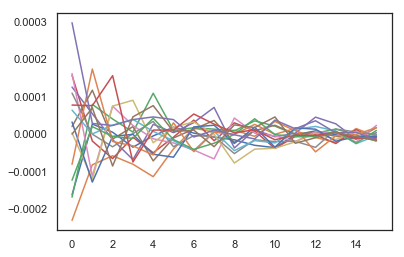

In [60]:

plt.plot(botts)


In [ ]:
cell, pos = get_honycomb_lattice(a=a, ncells=ncells)
h = get_hamiltonian(cell, pos)
val, vec = get_eigs(h)
hist, bins = np.histogram(val, bins=100)

ev, ec = -3, 3
mask = (val < ec ) & (val > ev)
print(np.array([pos[mask[::2]], pos[mask[1::2]]]))

%matplotlib inline

nvecs = mask.tolist().count(True)
fig = plt.figure()
ax = fig.gca()
ax.hist(val, bins=100)
_ax = ax.twinx()
dos = get_dos(bins, val, sigma=0.1)
_ax.plot(bins, dos, color='r')
_ax.set_ylim((0.0, None))
ax.grid()

fig, axes = plt.subplots(ncols=nvecs*2, figsize=(16, 4))
data = []
e = []
if np.any(mask):
    for i, (_vec, _val) in enumerate(zip(vec[mask], val[mask])):
        w = np.real(_vec.conjugate() * _vec)
        w_up, w_dn = w[::2], w[1::2]
        data.append(w_up)
        data.append(w_dn)
        e.extend([_val, _val])
        for _ax, _w in zip(axes[2*i:], (w_up, w_dn)):
            _ax.scatter(pos[:, 0], pos[:, 1], c=_w, s=12.0)
            _ax.grid()
            _ax.axis('equal')

data=np.array(data)
x, y = pos[:, 0], pos[:, 1]
n = len(data)
print(n)
df = DataFrame(data.T)
df['x']  = x
df['y'] = y

ncols=4
nrows = int(np.ceil(n/ncols))
print(data.shape)
print(ncols, nrows)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16,6*nrows))

for i in range(len(data)):
    _ix = i % ncols
    _iy = i // ncols
    _ax = axes[_iy, _ix]
    _ax.grid()
    _ax.axis('equal')
    _df = df[[i, 'x', 'y']]
    _ax.set_title('state {}  E={:8.4f}'.format(i, e[i]))
    p = sns.relplot(x='x', y='y', hue=i, size=i, 
            sizes=(40, 400), alpha=.5,
            height=6, data=_df, ax=_ax)


In [ ]:
def test_cell(a, c, ncells):

#    output_file("layout.html")
    cell, pos = get_random_lattice(a, ncells)

    # create a new plot
    s1 = figure(plot_width=250, plot_height=250, title=None)
    s1.circle(pos[:, 0], pos[:, 1], size=10, color="navy", alpha=0.5)

    cell, pos = get_honycomb_lattice(a, c, ncells)

    # create another one
    s2 = figure(plot_width=250, plot_height=250, title=None)
    s2.triangle(pos[:, 0], pos[:, 1], size=10, color="firebrick", alpha=0.5)

    return s1 ,s2 

s1, s2 = test_cell(a, c, ncells)
show(row(s1, s2))

In [ ]:
plt.hist(val)


In [ ]:
def make_plot(title, hist, edges, x, pdf, cdf):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend="PDF")
    p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend="CDF")

    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

hist, edges = np.histogram(val)
p = figure(title='eigenvalues', tools='')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:])
#p1 = make_plot("Normal Distribution", hist, edges, x, pdf, cdf)
#show(gridplot([p1,p2,p3,p4], ncols=2, plot_width=400, plot_height=400, toolbar_location=None))

#output_notebook()
t = show(p, notebook_handle=True)